##**Clasificación con métodos supervisados**

#### Clasificación de registros de trabajos en actividades con tareas y sin tareas pendientes usando métodos supervisados (KNN, Naive Bayes, Regresión Logística)

Se busca entrenar un modelo supervisado de clasificación a partir de los datos históricos de actividades, previamente etiquetados en "pendientes" y "no pendientes". El etiquetado se realizó apoyados en análisis de textos mediante métodos de NLP (lingüística computacional) 

In [ ]:
## Conectar el notebook a googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Se cargar las librerías a utilizar 
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model


**Cargar el conjunto de datos etiquetados**

In [ ]:
## df contiene los datos pendientes y no pendientes
df = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/datos_pendiente_Nopendiente.csv', encoding='utf-8')
#Habilitar la siguiente línea para correr el proyecto de manera local
#df = pd.read_csv('/content/datos_pendiente_Nopendiente.csv', encoding='utf-8')

Codificación de la etiqueta
* 1 = pendiente
* 0 = no pendiente

In [ ]:
df['label'] = np.where(df['pendiente'].isnull(),0,1)

In [ ]:
df = df[['WORKLOGID','tokens_proc','label']]
df.head(2)

,WORKLOGID,tokens_proc,label
0,2754950,"['revisa', 'poste', 'reventado', 'vehiculo', '...",0
1,3005990,"['localizar', 'falla', 'circuito', 'primario',...",0


In [ ]:
df['label'].value_counts()

0    146324
1     10468
Name: label, dtype: int64

Se observa un desbalanceo importante de las clases en el conjunto de datos

In [ ]:
nopend = df[df['label']==0]
pend = df[df['label']==1]

In [ ]:
nopend

,WORKLOGID,tokens_proc,label
0,2754950,"['revisa', 'poste', 'reventado', 'vehiculo', '...",0
1,3005990,"['localizar', 'falla', 'circuito', 'primario',...",0
2,2634320,"['retiraron', 'arbol', 'palma', 'aisladero', '...",0
3,2634321,"['cll', 'revision', 'calidad', 'inspecciona', ...",0
4,2742512,"['mar', 'carrera', 'trabajador', 'reparan', 'l...",0
...,...,...,...
156787,2927475,"['normalizo', 'aisladero', 'marcar', 'fase', '...",0
156788,3157566,"['legalizacion', 'ayer', 'solo', 'datos', 'asi...",0
156789,3056493,"['presto', 'pollo', 'cld', 'abrir', 'circuitos...",0
156790,3055378,"['aislo', 'reconectador', 'abrieron', 'cuchill...",0


Dado el desbalanceo de los datos, se determina hacer un *undersampling* de del conjunto de datos, específicamente de la clase 0 = no pendiente. Esto con el fin de obtener un set de datos balanceado para el entrenamiento de los modelos.



In [ ]:
## Dentro de la variable E1 se almacena una muestra de textos no pendientes igual tamaño a la cantidad de textos con pendiente
E1 = nopend.sample(n = 12000, replace = True)
Entrenamiento = pd.concat([E1, pend])
training_data = Entrenamiento.tokens_proc
training_etiquetas = Entrenamiento.label



*   División de los datos en conjuntos de prueba y entrenamiento



In [ ]:
## Se segmentan los datos en Datos de Entrenamiento y Datos de Testeo en una proporción 90% - 10%
x_train, x_test, y_train, y_test = train_test_split(training_data, training_etiquetas, test_size = 0.3)



*   Transformación de los datos a una representación numérica de documentos apropiada para aplicar los modelos supervisados. Se aplica la representación TF-IDF.



In [ ]:
# Se transforman los documentos a una matriz de frecuencia de tokens (CountVectorizer)
count_vect = CountVectorizer(max_features = 500)
X_train_counts = count_vect.fit_transform(x_train)

# Se transforma la matriz anterior a una representación TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [ ]:

# Se crea el vector de features para test
X_new_counts = count_vect.transform(x_test)

# Se usa la representación TF-IDF para test
X_new_tfidf = tfidf_transformer.transform(X_new_counts)


##Entrenamiento de modelo Knn

Se entrena un modelo KNN y se verifica su desempeño para diferentes valores de $k$, entre $1$ y $10$.

In [ ]:
## Se almacena la precisión del modelo dentro de la lista que lleva el mismo nombre
confianza = []

for i in range(1, 10):
    DF_Clasificador = KNeighborsClassifier(i)
    DF_Clasificador.fit(X_train_tfidf, y_train)
    confianza.append(DF_Clasificador.score(X_new_tfidf, y_test))

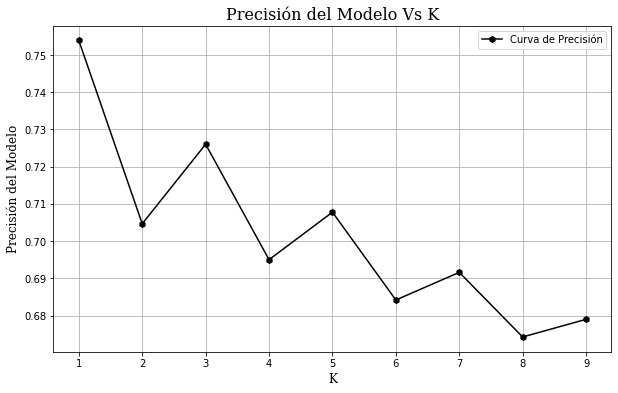

In [ ]:
### El gráfico representa la variación de la confianza del modelo conforme K aumenta; el gráfico se utiliza para seleccionar un K - óptimo

Figura = plt.figure(figsize = (10, 6))
ax = plt.subplot()

font_title = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }

font_label = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }


K = range(1,10)
#y_ticks = [0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]
#y_labels = ['70%', '71%', '72%', '73%', '74%', '75%', '76%', '77%', '78%']

ax.plot(K, confianza, color = 'k', markersize = 6, marker = 'h', label = 'Curva de Precisión')
ax.set_title('Precisión del Modelo Vs K', fontdict = font_title)
ax.set_xlabel('K', fontdict = font_label)
ax.set_ylabel('Precisión del Modelo', fontdict = font_label)

#ax.set_yticks(y_ticks)
#ax.set_yticklabels(y_labels)
plt.grid()
plt.legend()

plt.show()

A partir de la gráfica anterior, se identifica un valor de $k=3$ óptimo para el desempeño del modelo.

In [ ]:
## Modelo Knn con k=3
knn = KNeighborsClassifier(n_neighbors = 3)

# Entrenamiento del clasificador.
clf_knn = knn.fit(X_train_tfidf, y_train)

y_pred_knn = clf_knn.predict(X_new_tfidf)

* Evaluación de desempeño del modelo

In [ ]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      3557
           1       0.81      0.55      0.66      3184

    accuracy                           0.73      6741
   macro avg       0.75      0.72      0.71      6741
weighted avg       0.74      0.73      0.72      6741



##Entrenamiento de modelo Naive Bayes

* Entrenamiento del modelo

In [ ]:
 #Naive Bayes
nb = MultinomialNB().fit(X_train_tfidf, y_train)

# Entrenamiento del clasificador.
clf_nb = nb.fit(X_train_tfidf, y_train)

y_pred_nb = clf_nb.predict(X_new_tfidf)


* Evaluación de desempeño del modelo

In [ ]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      3557
           1       0.76      0.84      0.80      3184

    accuracy                           0.80      6741
   macro avg       0.80      0.80      0.80      6741
weighted avg       0.80      0.80      0.80      6741



##Entrenamiento de modelo Regresión Logística

* Entrenamiento del modelo

In [ ]:
 #Regresion logistica
rl = linear_model.LogisticRegression().fit(X_train_tfidf, y_train)

# Entrenamiento del clasificador.
clf_rl = rl.fit(X_train_tfidf, y_train)

y_pred_rl = clf_rl.predict(X_new_tfidf)


* Evaluación de desempeño del modelo

In [ ]:
print(classification_report(y_test, y_pred_rl))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3557
           1       0.94      0.98      0.96      3184

    accuracy                           0.96      6741
   macro avg       0.96      0.96      0.96      6741
weighted avg       0.96      0.96      0.96      6741



## Guardar los modelos entrenados para ser usados en el despliegue

In [ ]:
import pickle

filename = 'modelo.pkl'
variables= list(count_vect.get_feature_names_out())
pickle.dump([knn, nb, rl ,variables,count_vect,tfidf_transformer], open(filename, 'wb'))